In [1]:
import astropy.io.fits as fits
import des_functions
import treecorr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
import pyccl as ccl
from more_itertools import locate
from importlib import reload
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
data_dir = '/home/b7009348/WGL_project/DES-data/'

# Calculating F 

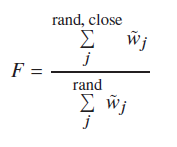

In [2]:
Image.open('F_equation.png')

- Difference in comoving distance, not redshift: 100Mpc/h
- Don't do it on a per galaxy basis (too computationally intense)
- Make finely binned histogram of lenses & source in Z
- Calculate comoving distance for each slice
- Include weights in histogram

### Loading and cutting data

In [2]:
# load in redmagic photo-z values for all lenses
with fits.open(data_dir+'DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits') as hdu:
    data = hdu[1].data
    lens_z = data['z']
del data

In [3]:
# load in source IDs for matched im3shape catalogue
with fits.open(data_dir+'y1_im3_shapes_matched.fits') as hdu:
    data = hdu[1].data
    im3_ID = data['coadd_objects_id']
    im3_weight = data['weight']
del data

In [4]:
# load in z_mc for all sources
with fits.open(data_dir+'mcal_BPZ_(binning).fits') as hdu:
    data = hdu[1].data
    im3_zmc = data['Z_MC']
    zmc_ID = data['COADD_OBJECTS_ID']
del data

In [5]:
with fits.open(data_dir+'y1_mcal_shapes_matched.fits') as hdu:
    data= hdu[1].data
    mcal_ID = data['coadd_objects_id']
    mcal_weight = data['R11']
del data

In [6]:
# match z_mc values to source IDs
matches, zmc_indices, shape_indices = np.intersect1d(zmc_ID, im3_ID, return_indices=True)

print(np.size(zmc_indices), np.size(im3_ID))
print(zmc_indices)

17814587 17814587
[        4        36        40 ... 134678888 134678905 134678967]


In [7]:
# slice z_mc values to only to those in matched catalogue
im3_zmc = im3_zmc[zmc_indices]

# delete uneccessary arrays
del matches, zmc_indices, shape_indices, zmc_ID

### Creating histogram data for lenses & sources

In [12]:
# set number of bins and code will bin date in range max-min zmc, incl. weights
nbins = 100

source_freq, source_bin_edges = np.histogram(im3_zmc, bins=nbins, range=(im3_zmc.min(), im3_zmc.max()), weights=im3_weight)

lens_freq, lens_bin_edges = np.histogram(lens_z, bins=nbins, range=(lens_z.min(), lens_z.max()))

In [13]:
# calculate bin width and find bin centers
source_binsz = np.mean(np.diff(source_bin_edges))
source_bin_centers = source_bin_edges[1:] - source_binsz/2.0

lens_binsz = np.mean(np.diff(lens_bin_edges))
lens_bin_centers = lens_bin_edges[1:] - lens_binsz/2.0

### Convert to comoving distance

In [14]:
# Set up cosmological parameters

OmegaM = 0.293
OmegaB = 0.0475
n_s = 1.0
sigma8 = 0.966
Ho = 70.8
h = Ho/100.0 # h = H0/100

# Set up a cosmology object, we need this to do calculations

cosmo = ccl.Cosmology(Omega_c = OmegaM-OmegaB, Omega_b = OmegaB, n_s = n_s, h = h, sigma8 = sigma8)

source_chi = ccl.comoving_radial_distance(cosmo, 1.0/(1.0+source_bin_centers))
lens_chi = ccl.comoving_radial_distance(cosmo, 1.0/(1.0+lens_bin_centers))

### Find 'rand,close'
- Only lens-source bin pairs within 100Mpc/h

In [5]:
close_pairs = []
old_rand_close = 0.0
for i in range(len(source_chi)):
    for j in range(len(lens_chi)):
        if abs(source_chi[i] - lens_chi[j]) <= 100.0:
            close_pairs.append((i, j))
            rand_close = old_rand_close + source_freq[i] * lens_freq[j]
            old_rand_close = rand_close

all_pairs = []
old_rand = 0.0
for i in range(len(source_chi)):
    for j in range(len(lens_chi)):
        all_pairs.append((i, j))
        rand = old_rand + source_freq[i] * lens_freq[j]
        old_rand = rand

NameError: name 'source_chi' is not defined

In [12]:
F = rand_close/rand
print(F)

0.07405504617872546


In [13]:
print(source_freq[4])
print(lens_freq[1])

7921776.598219698
100393


### Jackknife estimate for F with error

In [14]:
nbins = 100
F_i = []
index = np.arange(nbins)

for i in range(nbins):
    jk_source_freq = source_freq[index != i]
    jk_lens_freq = lens_freq[index != i]
    jk_source_chi = source_chi[index != i]
    jk_lens_chi = lens_chi[index != i]
    
    close_pairs = []
    old_rand_close = 0.0
    for j in range(len(jk_source_chi)):
        for k in range(len(jk_lens_chi)):
            if abs(jk_source_chi[j] - jk_lens_chi[k]) <= 100.0:
                close_pairs.append((j, k))
                rand_close = old_rand_close + jk_source_freq[j] * jk_lens_freq[k]
                old_rand_close = rand_close

    all_pairs = []
    old_rand = 0.0
    for j in range(len(jk_source_chi)):
        for k in range(len(jk_lens_chi)):
            all_pairs.append((j, k))
            rand = old_rand + jk_source_freq[j] * jk_lens_freq[k]
            old_rand = rand
            
    F = rand_close/rand 
    F_i.append(F)

In [15]:
F = np.mean(F_i)
Var_F = 1.0/nbins-1 * np.sum((F_i - F)**2)
print(F, Var_F)

0.07404823779577098 0.009935838669817041


In [25]:
reload(des_functions)
F, var_f = des_functions.calculate_F(nbins=810, source_z=im3_zmc, lens_z=lens_z, source_weights=im3_weight, npatches=30)
print(F, var_f)

810
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
[81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107]
[108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]
[135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161]
[162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188]
[189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215]
[216, 217, 218, 21

# Implementing calculation of F as a function and finding convergence for nbins

In [22]:
nbins = 100
F_old = des_functions.calculate_F(nbins=nbins, source_z=im3_zmc, lens_z=lens_z,
                                      source_weights=im3_weight)
x = [100]
y = [F_old]
F_diff = 1.0
while F_diff > 1e-7:
    nbins = nbins+10
    F = des_functions.calculate_F(nbins=nbins, source_z=im3_zmc, lens_z=lens_z,
                                      source_weights=im3_weight)
    F_diff = abs(F-F_old)
    F_old = F
    x.append(nbins)
    y.append(F)

In [19]:
print(F, nbins)

0.07522698037527152 430


In [20]:
print(y)

[0.07625467310941439, 0.07522245981593804, 0.07505334386538837, 0.07531562758146779, 0.07500332691388988, 0.07536923157040046, 0.07519867827758275, 0.07548132301794662, 0.07493713053938514, 0.07559875851409803, 0.07507804019830136, 0.07546157455476796, 0.07523242256568341, 0.07496260079872848, 0.0753210616372211, 0.0751431858193022, 0.07538240603545336, 0.07511155047633596, 0.07539814125858216, 0.07512689630174262, 0.07539298427985579, 0.07533159581041507, 0.07509727754537449, 0.07525140846482853, 0.07523379836212005, 0.07529479019441275, 0.07520444274617472, 0.0753385854471328, 0.07516189467468502, 0.0753736187226724, 0.07524803867167937, 0.07519820604047606, 0.0752264500547913, 0.07522698037527152]


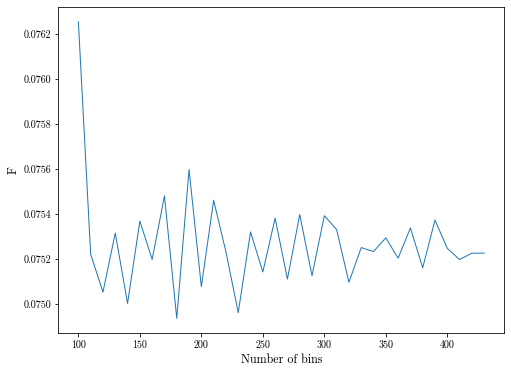

In [21]:
plt.figure(figsize=[8,6])
plt.plot(x, y, lw=1)
plt.annotate(r'$F = 0.0740$, Bins = $100$', xy=[100, 0.07398507470642227], xytext=[200, 0.0739], arrowprops=dict(arrowstyle='->'), fontsize=12)
plt.annotate(r'$F = 0.0729$, Bins = $810$', xy=[810, 0.07291571276552046], xytext=[620, 0.0734], arrowprops=dict(arrowstyle='->'), fontsize=12)
plt.xlabel('Number of bins', fontsize=12)
plt.ylabel('F', fontsize=12)
plt.savefig('F_convergence.png', dpi=300)

In [29]:
nbins = 810
patches = 30
patch_size = nbins/patches

data = np.arange(810)
old_lim = 0
for i in range(1,patches+1):
    index_lim = int(i*patch_size)
    print(index_lim)
    print(data[old_lim:index_lim])
    old_lim = index_lim

27
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
54
[27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53]
81
[54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77
 78 79 80]
108
[ 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107]
135
[108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134]
162
[135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161]
189
[162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188]
216
[189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215]
243
[216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242]
270
[243 244 245 246 247 248 249 250 251 252 253 

In [44]:
old_lim = 0
index_lim = 27
index = np.arange(int(nbins))
b = source_chi[old_lim:index_lim]
jk_source_chi = [x for x in source_chi if x not in b]
print(np.size(jk_source_chi))

73


In [20]:
F_i = []
nbins=100
npatches=20
patch_size = nbins/npatches
old_lim = 0
for k in range(1,npatches+1):
        
    index_lim = int(k*patch_size)
        
    b = source_chi[old_lim:index_lim]
    jk_source_chi = [x for x in source_chi if x not in b]
    print(b)
    print(np.size(jk_source_chi))
    b = lens_chi[old_lim:index_lim]
    jk_lens_chi = [x for x in lens_chi if x not in b]
        
    b = source_freq[old_lim:index_lim]
    jk_source_freq = [x for x in source_freq if x not in b]
        
    b = lens_freq[old_lim:index_lim]
    jk_lens_freq = [x for x in lens_freq if x not in b]
        
    # calculate rand,close
    old_rand_close = 0.0
    for i in range(len(jk_source_chi)):
        for j in range(len(jk_lens_chi)):
            if abs(jk_source_chi[i] - jk_lens_chi[j]) <= 100.0:
                rand_close = old_rand_close + jk_source_freq[i] * jk_lens_freq[j]
                old_rand_close = rand_close

    # calculate rand
    old_rand = 0.0
    for i in range(len(jk_source_chi)):
        for j in range(len(jk_lens_chi)):
            rand = old_rand + jk_source_freq[i] * jk_lens_freq[j]
            old_rand = rand
            
    # calculate F      
    F_i.append(rand_close/rand)
    old_lim = index_lim
        
F = np.mean(F_i)
var_f = 1.0/(npatches-1) * np.sum((F_i - F)**2)
print(F, var_f)

[ 94.79916893 240.35924689 383.56146241 524.36936549 662.75472524]
95
[ 798.69701191  932.18332176 1063.20795085 1191.77167711 1317.88161864]
95
[1441.55028507 1562.79565962 1681.64020638 1798.11036265 1912.23652001]
95
[2024.0519179  2133.59270871 2240.89725883 2346.00584612 2448.96049278]
95
[2549.80404381 2648.58065191 2745.33498496 2840.1120921  2932.95728212]
95
[3023.91591881 3113.03297824 3200.35343832 3285.92175323 3369.7817996 ]
95
[3451.97671816 3532.549317   3611.54132675 3688.99372129 3764.94665313]
95
[3839.43938869 3912.5102799  3984.19676815 4054.53541878 4123.56179697]
95
[4191.31025904 4257.81469696 4323.10794682 4387.22145506 4450.18664395]
95
[4512.03297168 4572.79011807 4632.48601631 4691.14808442 4748.80331284]
95
[4805.47718369 4861.19463687 4915.98032086 4969.85769207 5022.84948141]
95
[5074.97778129 5126.26404599 5176.72909576 5226.39313131 5275.27573527]
95
[5323.39585482 5370.77186979 5417.4216146  5463.36237149 5508.61086012]
95
[5553.18331107 5597.09547642 5

In [ ]:
npatches = 20

# load in redmagic photo-z values for all lenses
with fits.open(data_dir+'DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits') as hdu:
    data = hdu[1].data
    ra_l = data['ra']
    dec_l = data['dec']
    lens_z = data['z']
del data

print(lens_z)

cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', r=lens_z, npatch=npatches)

del ra_l, dec_l, lens_z

[0.24745971 0.22176833 0.21070513 ... 0.75858402 0.75454563 0.81837481]


In [ ]:
# load in source IDs for matched im3shape catalogue
with fits.open(data_dir+'y1_im3_shapes_matched.fits') as hdu:
    data = hdu[1].data
    im3_ID = data['coadd_objects_id']
    ra_im3 = data['RA']
    dec_im3 = data['DEC']
    im3_weight = data['weight']
del data

# load in z_mc for all sources
with fits.open(data_dir+'y1a1-gold-mof-badregion_BPZ.fits') as hdu:
    data = hdu[1].data
    im3_zmc = data['Z_MC']
    zmc_ID = data['COADD_OBJECTS_ID']
del data

# match z_mc values to source IDs
matches, zmc_indices, shape_indices = np.intersect1d(zmc_ID, im3_ID, return_indices=True)

print(shape_indices)

# slice z_mc values to only to those in matched catalogue
im3_zmc = im3_zmc[zmc_indices]

# delete uneccessary arrays
del matches, zmc_indices, shape_indices, zmc_ID

cat_s = treecorr.Catalog(ra=ra_im3, dec=dec_im3, ra_units='deg', dec_units='deg', r=im3_zmc, w=im3_weight, patch_centers=cat_l.patch_centers)

del ra_im3, dec_im3, im3_zmc, im3_weight

In [9]:
F_patches = np.zeros([npatches])

for i in range(npatches):
    
    l_indexes = list(locate(cat_l.patch, lambda x: x != i))
    s_indexes = list(locate(cat_s.patch, lambda x: x != i))
    
    print('Patch located, slicing redshift values from catalogue...')
    
    lens_z = cat_l.r[l_indexes]
    source_z = cat_s.r[s_indexes]
    source_weights = cat_s.w[s_indexes]
    
    print('Sliced, caluclating F_%g...' %i)
    
    F_patches[i] = des_functions.calculate_F(nbins=810, source_z=source_z, lens_z=lens_z, source_weights=source_weights)

    
F = 1.0/(npatches) * np.sum(F_patches)
var_F = 1.0/(npatches - 1) * np.sum((F_patches[:] - F)**2)

Patch located, slicing redshift values from catalogue...
Sliced, caluclating F_0...
Patch located, slicing redshift values from catalogue...
Sliced, caluclating F_1...
Patch located, slicing redshift values from catalogue...
Sliced, caluclating F_2...
Patch located, slicing redshift values from catalogue...
Sliced, caluclating F_3...
Patch located, slicing redshift values from catalogue...
Sliced, caluclating F_4...
Patch located, slicing redshift values from catalogue...
Sliced, caluclating F_5...
Patch located, slicing redshift values from catalogue...
Sliced, caluclating F_6...
Patch located, slicing redshift values from catalogue...
Sliced, caluclating F_7...
Patch located, slicing redshift values from catalogue...
Sliced, caluclating F_8...
Patch located, slicing redshift values from catalogue...
Sliced, caluclating F_9...
Patch located, slicing redshift values from catalogue...
Sliced, caluclating F_10...
Patch located, slicing redshift values from catalogue...
Sliced, caluclatin

In [10]:
print(F)
print(np.sqrt(var_F))

0.07300081348124497
5.249333523492787e-05


### Test for different weighting choices

In [10]:
im3_f = des_functions.calculate_F(nbins=810, 
                          source_z=im3_zmc, 
                          lens_z=lens_z, 
                          source_weights=im3_weight)
mcal_f = des_functions.calculate_F(nbins=810, 
                          source_z=im3_zmc, 
                          lens_z=lens_z, 
                          source_weights=mcal_weight)
control_F = des_functions.calculate_F(nbins=810, 
                          source_z=im3_zmc, 
                          lens_z=lens_z, 
                          source_weights=np.ones([len(im3_weight)]))

In [14]:
print(im3_f)
print(mcal_f)
print(control_F)

print((im3_f/mcal_f) *100)

0.07525969997262995
0.07559178985186693
0.07470541643617494
99.56067996287989
